In [44]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import seaborn as sns

from preprocess import get_prepared_data

if torch.backends.mps.is_available():
    mps_device = torch.device("mps")
    x = torch.ones(1, device=mps_device)
    print (x)
else:
    print ("MPS device not found.")

tensor([1.], device='mps:0')


In [45]:
# Load and prepare data
X, y = get_prepared_data(oversample=False, relabel=False)

# Convert labels to categorical format if needed
y = y.astype('int64')  # Ensure labels are integers

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [46]:
# Build RNN model
class RNNModel(nn.Module):
    def __init__(self, input_size=178, hidden_size=64, num_classes=5):
        super(RNNModel, self).__init__()
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
        
    def forward(self, x):
        # Reshape input to (batch_size, sequence_length, input_size)
        x = x.unsqueeze(1)  # Add sequence dimension
        
        # Initialize hidden state
        h0 = torch.zeros(1, x.size(0), self.hidden_size).to(x.device)
        
        # Forward propagate RNN
        out, _ = self.rnn(x, h0)
        
        # Decode hidden state of last time step
        out = self.fc(out[:, -1, :])
        return out

# Initialize model with proper vocab size
model = RNNModel(input_size=178, hidden_size=64, num_classes=6)

# Compile the model
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [51]:
# Prepare data loaders
train_data = TensorDataset(torch.FloatTensor(X_train), torch.LongTensor(y_train))
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)

# Train the model
epochs = 50
for epoch in range(epochs):
    model.train()
    epoch_loss = 0
    epoch_acc = 0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        # Calculate accuracy
        _, predicted = torch.max(outputs.data, 1)
        acc = (predicted == labels).float().mean()
        
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()

    print(f'Epoch {epoch+1}/{epochs}:')
    print(f'Loss: {epoch_loss/len(train_loader):.4f}')
    print(f'Accuracy: {epoch_acc/len(train_loader):.4f}')

Epoch 1/50:
Loss: 0.8086
Accuracy: 0.6568
Epoch 2/50:
Loss: 0.7807
Accuracy: 0.6689
Epoch 3/50:
Loss: 0.7591
Accuracy: 0.6742
Epoch 4/50:
Loss: 0.7378
Accuracy: 0.6837
Epoch 5/50:
Loss: 0.7199
Accuracy: 0.6914
Epoch 6/50:
Loss: 0.7037
Accuracy: 0.6934
Epoch 7/50:
Loss: 0.6901
Accuracy: 0.7025
Epoch 8/50:
Loss: 0.6737
Accuracy: 0.7070
Epoch 9/50:
Loss: 0.6623
Accuracy: 0.7120
Epoch 10/50:
Loss: 0.6504
Accuracy: 0.7224
Epoch 11/50:
Loss: 0.6377
Accuracy: 0.7285
Epoch 12/50:
Loss: 0.6265
Accuracy: 0.7303
Epoch 13/50:
Loss: 0.6193
Accuracy: 0.7325
Epoch 14/50:
Loss: 0.6091
Accuracy: 0.7400
Epoch 15/50:
Loss: 0.5994
Accuracy: 0.7393
Epoch 16/50:
Loss: 0.5908
Accuracy: 0.7467
Epoch 17/50:
Loss: 0.5840
Accuracy: 0.7514
Epoch 18/50:
Loss: 0.5741
Accuracy: 0.7553
Epoch 19/50:
Loss: 0.5681
Accuracy: 0.7594
Epoch 20/50:
Loss: 0.5617
Accuracy: 0.7615
Epoch 21/50:
Loss: 0.5569
Accuracy: 0.7635
Epoch 22/50:
Loss: 0.5490
Accuracy: 0.7669
Epoch 23/50:
Loss: 0.5422
Accuracy: 0.7704
Epoch 24/50:
Loss: 0

In [52]:
# Predict and evaluate
model.eval()
with torch.no_grad():
    X_test_tensor = torch.FloatTensor(X_test)
    outputs = model(X_test_tensor)
    _, predicted = torch.max(outputs.data, 1)
    y_pred = predicted.numpy()
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           1       0.93      0.87      0.90       456
           2       0.50      0.58      0.54       455
           3       0.54      0.50      0.52       455
           4       0.72      0.72      0.72       456
           5       0.63      0.60      0.61       455

    accuracy                           0.66      2277
   macro avg       0.66      0.66      0.66      2277
weighted avg       0.66      0.66      0.66      2277



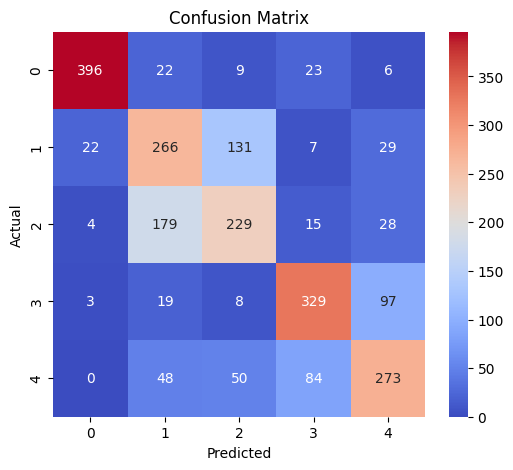

In [53]:
def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, cmap="coolwarm", fmt='d')
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

plot_confusion_matrix(y_test, y_pred)

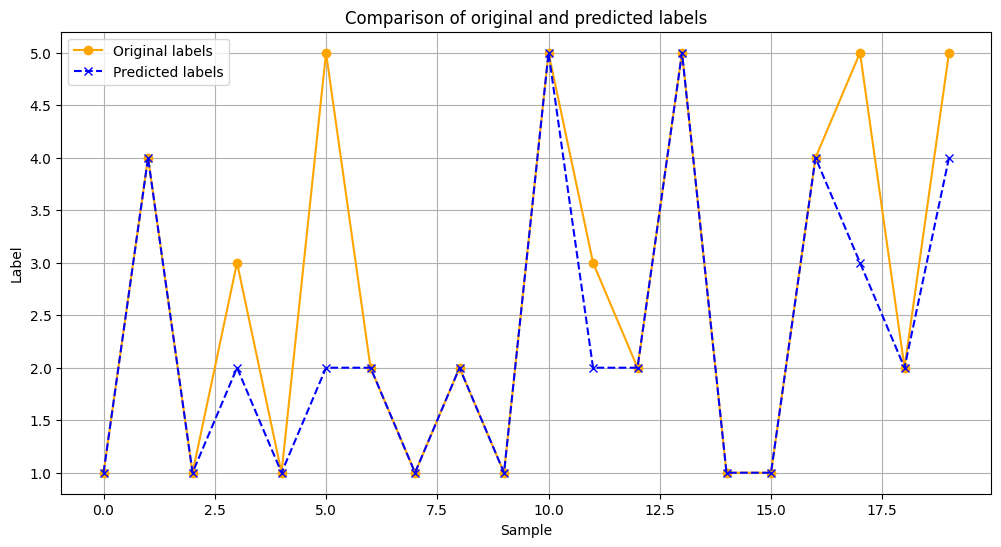

In [54]:
# Plot comparison of original and predicted labels
num_samples_to_plot = 20
indices = np.arange(num_samples_to_plot)
original_labels = y_test[:num_samples_to_plot]
predicted_labels = y_pred[:num_samples_to_plot]

plt.figure(figsize=(12, 6))
plt.plot(indices, original_labels, marker='o', linestyle='-', color='orange', label='Original labels')
plt.plot(indices, predicted_labels, marker='x', linestyle='--', color='blue', label='Predicted labels')
plt.xlabel("Sample")
plt.ylabel("Label")
plt.title("Comparison of original and predicted labels")
plt.legend()
plt.grid(True)
plt.show()